### Figure 3

Genetic Interaction validation box plots

In [164]:
import glob
import numpy as np
import torch
import scanpy as sc
import pandas as pd 
import copy
import sys
import scipy
sys.path.append('../')
import os
from data import PertDataloader
from inference import evaluate, compute_metrics
from inference import GIs
import matplotlib.patches as mpatches

# Linear model fitting functions
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from dcor import distance_correlation, partial_distance_correlation
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from fig_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [311]:
font = {'family' : 'normal',
        'size'   : 18}

import matplotlib
matplotlib.rc('font', **font)

In [3]:
def get_all_vals(res):
    return np.hstack([v for v in res.values()])

def get_extremes(res):
    all_vals = remove_nan(get_all_vals(res))
    return [np.min(all_vals), np.max(all_vals)]

def get_mean(res):
    all_vals = remove_nan(get_all_vals(res))
    return np.mean(all_vals)

In [4]:
ticklabel_map = {'synergy': 'Synergy',
                 'suppressor':'Suppression',
                 'neomorphic':'Neomorphism',
                 'redundant':'Redundancy',
                 'epistasis':'Epistasis',
                'additive':'Additivity'}

### Fixing CPA file naming

In [208]:
dict_names = glob.glob('/dfs/user/yhr/CPA_orig/compert/GI_subtypes_out/*.npy')

In [206]:
## Renaming CPA output files
import os 

dict_names = glob.glob('/dfs/user/yhr/CPA_orig/compert/GI_subtypes_out/rep4/*.npy')
for GI in GI_names:
    for d in dict_names:
        pert_name = d.split('/')[-1].split('.npy')[0]
        if pert_name in GIs[GI.upper()]:
            old_name = d
            new_name = '/'.join(dict_names[0].split('/')[:-1]) + '/' + GI + '_' + d.split('/')[-1]
            print(old_name, new_name)
            #os.rename(old_name, new_name)

In [207]:
# Adding truth values to CPA runs

cpa_names = glob.glob('/dfs/user/yhr/CPA_orig/compert/GI_subtypes_out/rep4/*.npy')
# List the new output files that have to be edited
new_outputs = []

for d in cpa_names:
    #if d.split('_')[-1].split('.npy')[0] in new_outputs:
    if '+' in d:
    #if 'other' in d:
        X = np.load(d, allow_pickle=True)
        try:
            X = X.item()
            for k in X.keys():
                X[k] = X[k][1]
        except:
            X = {X[0]:X[1]}

        for k in X.keys():
            try:
                X[k]['truth'] = get_truth(k)
            except:
                pass
        np.save(d, X)

## Method comparison

In [224]:
# SET ------------
metric = 'mag'
GI_sel = 'additive'
# ------------

# Filenames
#crossgene_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/*crossgene*.npy')
crossgene_names = glob.glob('/dfs/user/yhr/snap/perturb_GNN/pertnet-cli/GI_subtypes_out_v2/*crossgene*.npy')

coexp_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/*coexp*.npy')
baseline_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/no_crossgene_baseline/*.npy')
cpa_names = glob.glob('/dfs/user/yhr/CPA_orig/compert/GI_subtypes_out/*.npy')
naive_seen2_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/*naive*seen2*.npy')

# Seen 2
res_p_seen2_base, _ = get_t_p_seen2(metric, baseline_names)
res_p_seen2_cg, res_t_seen2 = get_t_p_seen2(metric, crossgene_names)
res_p_seen2_cpa, _ = get_t_p_seen2(metric, cpa_names)
res_p_seen2_naive, _ = get_t_p_seen2_naive(metric, naive_seen2_names[0])

In [45]:
# Seen 2 computations
def get_box_scatter_inputs(res_p_seen2, res_t_seen2, GI_sel):
    res_p_seen2_small = {}
    res_p_seen2_small[GI_sel] = res_p_seen2[GI_sel]

    res_t_seen2_small = {}
    res_t_seen2_small[GI_sel] = res_t_seen2[GI_sel]

    xs, preds, trues, labels = set_up_box_scatter(GI_sel, res_p_seen2_small, res_t_seen2_small, metric)
    return xs, preds, trues, labels 

xs = []
preds = []
trues = []
labels = []
extremes = []
means = []
extremes.append(get_extremes(res_t_seen2))
means.append(get_mean(res_t_seen2))

for res_p, res_t in zip([res_p_seen2_cg,   res_p_seen2_cpa, res_p_seen2_naive],
                        [res_t_seen2, res_t_seen2,  res_t_seen2]):
    x, pred, true, label = get_box_scatter_inputs(res_p, res_t, GI_sel=GI_sel)
    xs.append(x[0])
    preds.append(pred)
    trues.append(true)
    labels.append(label)
    extremes.append(get_extremes(res_p))
    means.append(get_mean(res_p))

In [46]:
trues = [ [remove_nan(t[0])] for t in trues]
preds = [ [remove_nan(p[0])] for p in preds]
n = len(preds[0][0])

(0.0, 5.0)

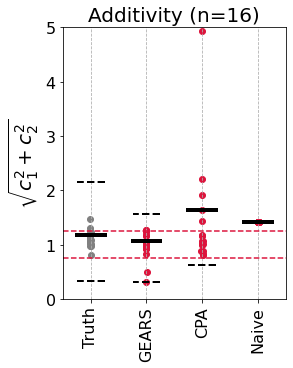

In [48]:
ticklabels=['Truth', 'GEARS', 'CPA', 'Naive']

make_comp_box_scatter(xs, preds, trues, n_preds=0, labels=labels, GI=GI_sel, 
                      title=ticklabel_map[GI_sel].title() + ' (n=' + str(n) +')', 
                 ylabel=latex_names[metric], scatter=True,
                xticks=False, GIs=metric_GI_map[metric], seen=1, 
                 pred_color=colors[metric][0], shade_color=colors[metric][0], 
                 ticklabels=ticklabels, skip_last_scatter=True, extremes=extremes, means=means,
                legend=False)

plt.ylim([0,5])

### Scatter only plots

In [116]:
# SET ------------
metric = 'dcor'
GI_sel = 'synergy'
# ------------

# Filenames
#crossgene_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/*crossgene*.npy')
crossgene_names = glob.glob('/dfs/user/yhr/snap/perturb_GNN/pertnet-cli/GI_subtypes_out_v2/*crossgene*.npy')

coexp_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/*coexp*.npy')
baseline_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/no_crossgene_baseline/*.npy')
cpa_names = glob.glob('/dfs/user/yhr/CPA_orig/compert/GI_subtypes_out/*.npy')
naive_seen2_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/*naive*seen2*.npy')

# Seen 2
res_p_seen2_base, _ = get_t_p_seen2(metric, baseline_names)
res_p_seen2_cg, res_t_seen2_cg = get_t_p_seen2(metric, crossgene_names)
res_p_seen2_cpa, res_t_seen2_cpa = get_t_p_seen2(metric, cpa_names)
res_p_seen2_naive, _ = get_t_p_seen2_naive(metric, naive_seen2_names[0])
res_t_seen2 = res_t_seen2_cg

# Synergy
res_p_seen2_cg['synergy'] = res_p_seen2_cg['potentiation'] + res_p_seen2_cg['synergy_similar_pheno'] + res_p_seen2_cg['synergy_dissimilar_pheno']
res_p_seen2_cpa['synergy'] = res_p_seen2_cpa['potentiation'] + res_p_seen2_cpa['synergy_similar_pheno'] + res_p_seen2_cpa['synergy_dissimilar_pheno']
res_p_seen2_naive['synergy'] = res_p_seen2_naive['potentiation'] + res_p_seen2_naive['synergy_similar_pheno'] + res_p_seen2_naive['synergy_dissimilar_pheno']
res_t_seen2['synergy'] = res_t_seen2['potentiation'] + res_t_seen2['synergy_similar_pheno'] + res_t_seen2['synergy_dissimilar_pheno']



In [117]:
def plot_scatter(res_p, res_t, GI_sel, metric, 
                 pred_color, ylab, title):
    
    plt.figure(figsize=[5,5])
    preds = get_all_vals(res_p)
    truths = get_all_vals(res_t)
    
    df = pd.DataFrame([truths, preds]).T
    df = df.dropna()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df[0].values, df[1].values)
    
    plt.scatter(truths, preds, color=pred_color, alpha=0.6)

    preds = np.array(remove_nan(preds))
    truths = np.array(remove_nan(truths))
    

    
    all_max = np.max([preds.max(), truths.max()])
    all_min = np.min([preds.min(), truths.min()])

    """
    plt.xlim([np.min(truths)-np.max(truths)/20, np.max(truths)+np.max(truths)/20])
    plt.ylim([np.min(preds)-np.max(preds)/20, np.max(preds)+np.max(preds)/20])
    """
    
    plt.xlim([all_min-all_max/20, all_max+all_max/20])
    plt.ylim([all_min-all_max/20, all_max+all_max/20])
    
    plt.axline((0, 0), (1, 1), linewidth=2, linestyle='--', color='k')
    
    plt.annotate(r'$R^2=${0:.2f}'.format(r_value**2), 
                 (all_min, all_max-all_max/10))
    plt.xlabel('Truth')
    
    plt.ylabel(ylab)
    if (title):
        plt.title(title)
    
    #plt.plot([thresh[GI_sel], thresh[GI_sel]], 
    #         [thresh[GI_sel], np.max(preds)+0.25], color=colors[metric][0])
    #plt.plot([thresh[GI_sel], np.max(truths)+0.25], 
    #         [thresh[GI_sel], thresh[GI_sel]], color=colors[metric][0])

In [118]:
del(res_t_seen2_cg['synergy'])
del(res_p_seen2_cg['synergy'])
del(res_t_seen2_cpa['synergy'])
del(res_p_seen2_cpa['synergy'])

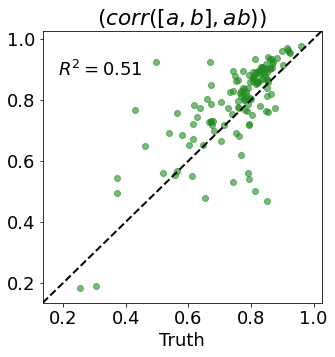

In [119]:
plot_scatter(res_p_seen2_cg, res_t_seen2_cg, 
             GI_sel, metric, pred_color =colors[metric][0],
             ylab='', title=latex_names[metric])

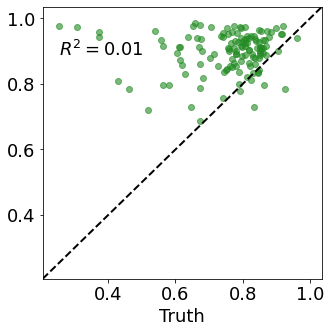

In [120]:
plot_scatter(res_p_seen2_cpa, res_t_seen2_cpa, 
             GI_sel, metric, pred_color =colors[metric][0],
             ylab='', title=None)

### Seen 1

In [225]:
genes_of_interest = ['AHR', 'ARID1A', 'ARRDC3', 'ATL1', 'BCORL1', 'BPGM', 'C19orf26',
'CBFA2T3', 'CBL', 'CDKN1A', 'CDKN1B', 'CDKN1C', 'CEBPA', 'CEBPB',
'CEBPE', 'CELF2', 'CITED1', 'CKS1B', 'CLDN6', 'CNN1', 'CNNM4',
'COL1A1', 'COL2A1', 'CSRNP1', 'DLX2', 'DUSP9', 'EGR1', 'ELMSAN1',
'ETS2', 'FEV', 'FOSB', 'FOXA1', 'FOXA3', 'FOXF1', 'FOXL2',
'C3orf72', 'FOXO4', 'GLB1L2', 'HES7', 'HK2', 'HNF4A', 'HOXA13',
'HOXB9', 'HOXC13', 'IER5L', 'IGDCC3', 'IKZF3', 'IRF1', 'JUN',
'KIF18B', 'KLF1', 'LHX1', 'LYL1', 'MAML2', 'MAP2K3', 'MAP2K6',
'MAPK1', 'MEIS1', 'MIDN', 'NIT1', 'OSR2', 'POU3F2', 'PRDM1',
'PRTG', 'PTPN1', 'PTPN12', 'PTPN13', 'PTPN9', 'RHOXF2BB',
'KIAA1804', 'RREB1', 'S1PR2', 'SAMD1', 'SET', 'SGK1', 'SLC38A2',
'SLC4A1', 'SLC6A9', 'SNAI1', 'SPI1', 'TBX2', 'TBX3', 'TMSB4X',
'TP73', 'TSC22D1', 'UBASH3A', 'UBASH3B', 'ZBTB1', 'ZBTB10',
'ZBTB25', 'ZC3HAV1', 'ZNF318']

In [440]:
# SET ------------
metric = 'eq_contr'
GI_sel = 'synergy'
# ------------

# Filenames
#crossgene_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/*crossgene*.npy')
crossgene_names = glob.glob('/dfs/user/yhr/snap/perturb_GNN/pertnet-cli/GI_subtypes_out_v3/*crossgene*.npy')

coexp_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/*coexp*.npy')
baseline_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/no_crossgene_baseline/*.npy')
cpa_names = glob.glob('/dfs/user/yhr/CPA_orig/compert/GI_subtypes_out/*.npy')
naive_seen2_names = glob.glob('/dfs/user/yhr/perturb_GNN/pertnet/GI_subtypes_out_v2/*naive*seen2*.npy')

# Seen 1
res_p_seen1_base, _ = get_t_p_seen1(metric, baseline_names)
res_p_seen1_cg, res_t_seen1_cg = get_t_p_seen1(metric, crossgene_names, uncert_filter=True)
res_p_seen1_cpa, res_t_seen1_cpa = get_t_p_seen1(metric, cpa_names)
res_t_seen1 = res_t_seen1_cg

## Assuming seen1 naive is same as seen 2
res_p_seen1_naive, _ = get_t_p_seen2_naive(metric, naive_seen2_names[0])


#res_p_seen1_cg['synergy'] = res_p_seen1_cg['potentiation'] + res_p_seen1_cg['synergy_similar_pheno'] + res_p_seen1_cg['synergy_dissimilar_pheno']
#res_p_seen1_cpa['synergy'] = res_p_seen1_cpa['potentiation'] + res_p_seen1_cpa['synergy_similar_pheno'] + res_p_seen1_cpa['synergy_dissimilar_pheno']
#res_p_seen1_naive['synergy'] = res_p_seen1_naive['potentiation'] + res_p_seen1_naive['synergy_similar_pheno'] + res_p_seen1_naive['synergy_dissimilar_pheno']
#res_t_seen1['synergy'] = res_t_seen1['potentiation'] + res_t_seen1['synergy_similar_pheno'] + res_t_seen1['synergy_dissimilar_pheno']



In [441]:
del(res_p_seen1_cg['synergy'])
del(res_t_seen1_cg['synergy'])

In [442]:
np.sum(get_all_vals(res_t_seen1_cg)<0.30)
#np.sum(vs>1.15)/len(vs)

13

In [418]:
len(get_all_vals(res_t_seen1_cg))

117

In [419]:
# Nan replacing for epistasis only
"""
for k in res_p_seen1_cpa:
    res_p_seen1_cpa[k] = np.nan_to_num(res_p_seen1_cpa[k])
"""

'\nfor k in res_p_seen1_cpa:\n    res_p_seen1_cpa[k] = np.nan_to_num(res_p_seen1_cpa[k])\n'

In [420]:
# Seen 1 computations
def get_box_scatter_inputs(res_p_seen1, res_t_seen1, GI_sel):
    res_p_seen1_small = {}
    res_p_seen1_small[GI_sel] = res_p_seen1[GI_sel]

    res_t_seen1_small = {}
    res_t_seen1_small[GI_sel] = res_t_seen1[GI_sel]

    xs, preds, trues, labels = set_up_box_scatter(GI_sel, res_p_seen1_small, res_t_seen1_small, metric)
    return xs, preds, trues, labels 

xs = []
preds = []
trues = []
labels = []
extremes = []
means = []
extremes.append(get_extremes(res_t_seen1))
means.append(get_mean(res_t_seen1))

for res_p, res_t in zip([res_p_seen1_cg],
                        [res_t_seen1]):
    x, pred, true, label = get_box_scatter_inputs(res_p, res_t, GI_sel=GI_sel)
    xs.append(x[0])
    preds.append(pred)
    trues.append(true)
    labels.append(label)
    extremes.append(get_extremes(res_p))
    means.append(get_mean(res_p))


In [421]:
trues = [ [remove_nan(t[0])] for t in trues]
preds = [ [remove_nan(p[0])] for p in preds]
n = len(preds[0][0])

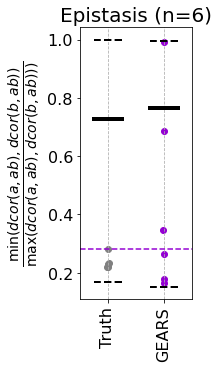

In [422]:
ticklabels=['Truth', 'GEARS']

make_comp_box_scatter(xs, preds, trues, n_preds=0, labels=labels, 
                      title=ticklabel_map[GI_sel].title() + ' (n=' + str(n) +')', 
                 ylabel=latex_names[metric], scatter=True,
                xticks=False, GIs=metric_GI_map[metric], seen=1, 
                 pred_color=colors[metric][0], shade_color=colors[metric][0], GI=GI_sel,
                 ticklabels=ticklabels, skip_last_scatter=True, extremes=extremes, means=means,
                legend=False)

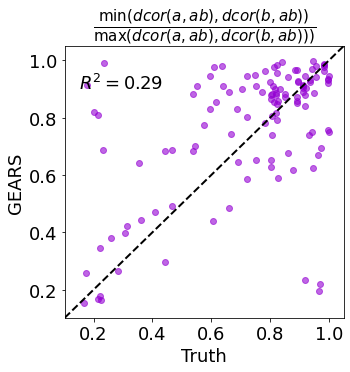

In [423]:
plot_scatter(res_p_seen1_cg, res_t_seen1, 
             GI_sel, metric, pred_color =colors[metric][0],
             ylab='GEARS', title=latex_names[metric])